# LAB 4.1 - Convolutions

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

replicating local resources


In [188]:
from local.lib.rlxmoocapi import submit, session
student = session.Session(init.endpoint).login( course_id=init.course_id, lab_id="L04.01" )

username: davida.torres@udea.edu.co
password: ··········
using session UDEA


In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.4.1'

## TASK 1: Implement convolutions

Complete the following function so that it implements a convolution in a set of `for` loops. **YOU CANNOT USE TENSORFLOW**

The parameters of the function are as follow:

- `img`: the images, an array of size [1,y,x,k], where:
    - `1`: you will be receiving only one image
    - `x`, `y`: the size of the image
    - `k` : the number of channels
    
- `f`: the filters, an array of size [fy,fx,k,n], where:
    - `fx`, `fy`: the size of the filters
    - `k` : the number of channels (**must be the same as in images**)
    - `n`: the number of filters
- `activation`: the activation function to use (such as `sigmoid` or `linear` as shown below)


the resulting activation map must be of shape `[1, x-fx+1, y-fy+1, n]` which is equivalent to a `Conv2D`  Keras layer with `padding='VALID'`

In [141]:
sigmoid = lambda x: 1/(1+np.exp(-x))
linear  = lambda x: x

def convolution_byhand(img, f, activation=sigmoid):
    assert f.shape[2]==img.shape[3]
    fy = f.shape[0]
    fx = f.shape[1]
    r = np.zeros( (1, img.shape[1]-fy+1, img.shape[2]-fx+1, f.shape[3] ))
    for filter_nb in range(f.shape[3]):      
        for y in range(r.shape[1]):
            for x in range(r.shape[2]):
              y_idx = fy+y
              x_idx = fx+x
              r[0,y,x,filter_nb] = activation((img[0,y:y_idx,x:x_idx]*f[:,:,:,filter_nb]).sum());
    return r

with the following 5x5x1 image and 2 filters of size 3x3x1 you should get this result

        >> convolution_byhand(img, f, activation=sigmoid)
        array([[[[0.7109495 , 0.37754067],
                 [0.40131234, 0.35434369],
                 [0.40131234, 0.40131234]],

                [[0.450166  , 0.5       ],
                 [0.59868766, 0.40131234],
                 [0.2890505 , 0.42555748]],

                [[0.19781611, 0.64565631],
                 [0.81757448, 0.75026011],
                 [0.2890505 , 0.66818777]]]])

In [132]:
img = np.r_[[[0, 8, 5, 9, 7],
             [0, 6, 4, 6, 9],
             [6, 3, 8, 4, 5],
             [8, 7, 7, 4, 5],
             [7, 2, 5, 0, 2]]].reshape((1,5,5,1))/10 - 0.5
f = np.r_[[-1., -1.,  1., -1., -1., -1., -1.,  1.,  1.],
          [ 1., -1.,  1., -1., -1.,  1., -1., -1., -1.]].reshape(3,3,1,2)
convolution_byhand(img, f, activation=sigmoid)

(1, 5, 5, 1)
(1, 3, 3, 2)


array([[[[0.7109495 , 0.37754067],
         [0.40131234, 0.35434369],
         [0.40131234, 0.40131234]],

        [[0.450166  , 0.5       ],
         [0.59868766, 0.40131234],
         [0.2890505 , 0.42555748]],

        [[0.19781611, 0.64565631],
         [0.81757448, 0.75026011],
         [0.2890505 , 0.66818777]]]])

which should yield the same result as simply applying a keras `Conv2D` layer

In [133]:
c = tf.keras.layers.Conv2D(filters=f.shape[-1], kernel_size=f.shape[:2], activation="sigmoid", padding='VALID', dtype=tf.float64)
c.build(input_shape=(1,7,7,f.shape[2]))   # any shape would do here, just initializing weights
c.set_weights([f, np.zeros(2)])
c(img).numpy()

array([[[[0.7109495 , 0.37754067],
         [0.40131234, 0.35434369],
         [0.40131234, 0.40131234]],

        [[0.450166  , 0.5       ],
         [0.59868766, 0.40131234],
         [0.2890505 , 0.42555748]],

        [[0.19781611, 0.64565631],
         [0.81757448, 0.75026011],
         [0.2890505 , 0.66818777]]]])

you can also check the effect of the filters in a sample image

(1, 32, 32, 1)
(1, 30, 30, 2)


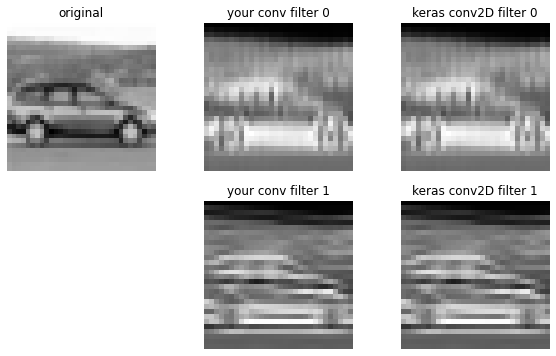

In [135]:

from skimage import io
img = io.imread("local/imgs/sample_img.png")
img = img.reshape(1,*img.shape, 1)
img = (img-np.min(img))/(np.max(img)-np.min(img))
a1 = convolution_byhand(img, f)
a2 = c(img).numpy()

plt.figure(figsize=(10,6))
plt.subplot(231); plt.imshow(img[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("original")
plt.subplot(232); plt.imshow(a1[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("your conv filter 0")
plt.subplot(233); plt.imshow(a2[0,:,:,0], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("keras conv2D filter 0")
plt.subplot(235); plt.imshow(a1[0,:,:,1], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("your conv filter 1")
plt.subplot(236); plt.imshow(a2[0,:,:,1], cmap=plt.cm.Greys_r); plt.axis("off"); plt.title("keras conv2D filter 1");


**Registra tu solución en linea**

In [136]:
student.submit_task(namespace=globals(), task_id='T1');

## TASK 2: Prepare image for one-shot convolution

We will prepare images to do the convolution with one dot product operation for each filter and each image. This will use more memory but will increase performance, specially if we have many filters.

For instance, assume we have the following 1x8x6x1 images (only one image, one channel) and 2x3x1x2 filters (one channel, two filters)

In [144]:
img = np.r_[[9, 4, 9, 6, 7, 1, 2, 2, 8, 0, 8, 6, 8, 6, 5, 5, 1, 4, 3, 4, 4, 4,
             3, 6, 5, 1, 7, 9, 1, 4, 0, 3, 1, 4, 3, 5, 1, 5, 5, 4, 9, 6, 3, 2,
             8, 9, 0, 6]].reshape(1,8,6,1)
f = np.r_[[6, 7, 8, 5, 2, 9, 6, 4, 9, 7, 9, 7]].reshape(2,3,1,2)
print ("images", img.shape)
print (img[0,:,:,0])
print ("--")
print ("filters", f.shape)
print (f[:,:,0,0])
print (f[:,:,0,1])

images (1, 8, 6, 1)
[[9 4 9 6 7 1]
 [2 2 8 0 8 6]
 [8 6 5 5 1 4]
 [3 4 4 4 3 6]
 [5 1 7 9 1 4]
 [0 3 1 4 3 5]
 [1 5 5 4 9 6]
 [3 2 8 9 0 6]]
--
filters (2, 3, 1, 2)
[[6 8 2]
 [6 9 9]]
[[7 5 9]
 [4 7 7]]


observe that if we repeat and rearrange `img` in the following way

In [138]:
pimg = np.array([[[[9., 4., 9., 2., 2., 8.],
         [4., 9., 6., 2., 8., 0.],
         [9., 6., 7., 8., 0., 8.],
         [6., 7., 1., 0., 8., 6.]],

        [[2., 2., 8., 8., 6., 5.],
         [2., 8., 0., 6., 5., 5.],
         [8., 0., 8., 5., 5., 1.],
         [0., 8., 6., 5., 1., 4.]],

        [[8., 6., 5., 3., 4., 4.],
         [6., 5., 5., 4., 4., 4.],
         [5., 5., 1., 4., 4., 3.],
         [5., 1., 4., 4., 3., 6.]],

        [[3., 4., 4., 5., 1., 7.],
         [4., 4., 4., 1., 7., 9.],
         [4., 4., 3., 7., 9., 1.],
         [4., 3., 6., 9., 1., 4.]],

        [[5., 1., 7., 0., 3., 1.],
         [1., 7., 9., 3., 1., 4.],
         [7., 9., 1., 1., 4., 3.],
         [9., 1., 4., 4., 3., 5.]],

        [[0., 3., 1., 1., 5., 5.],
         [3., 1., 4., 5., 5., 4.],
         [1., 4., 3., 5., 4., 9.],
         [4., 3., 5., 4., 9., 6.]],

        [[1., 5., 5., 3., 2., 8.],
         [5., 5., 4., 2., 8., 9.],
         [5., 4., 9., 8., 9., 0.],
         [4., 9., 6., 9., 0., 6.]]]])


In [143]:
print(pimg.shape)
print(
    img.shape)


(1, 7, 4, 6)
(1, 8, 6, 1)


we only need one `dot` operation to obtain the convolution

In [139]:

pimg[0].dot(f[:,:,:,0].flatten())


array([[206., 192., 236., 220.],
       [191., 202., 148., 151.],
       [196., 182., 159., 151.],
       [160., 214., 194., 159.],
       [ 88., 143., 185., 166.],
       [122., 145., 191., 217.],
       [164., 243., 209., 216.]])

which we can compare with your previous function

In [140]:

convolution_byhand(img, f, activation=linear)[0,:,:,0]


(1, 8, 6, 1)
(1, 7, 4, 2)


array([[206., 192., 236., 220.],
       [191., 202., 148., 151.],
       [196., 182., 159., 151.],
       [160., 214., 194., 159.],
       [ 88., 143., 185., 166.],
       [122., 145., 191., 217.],
       [164., 243., 209., 216.]])

observe that:

- resulting images in this example after convolution with any filter will have size 7x4
- the resulting structure `pimg` has at each pixel (in the 7x4 grid) a vector of six elements associated with it.
- this vector is the flattened contents of 2x3x1 image fragment located at that pixel that would by multiplied element by element by any filter located at that pixel during the convolution.
- the first row in `pimg` corresponds to the flattened 2x3 fragment located at the top left corner of `img`
- the second row contains the 2x3 fragment after shifting one pixel to the right.
- we use the [`np.flatten`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html) operation. 


**COMPLETE** the following function such that it prepares an image in this way, so that the convolution with a filter is just a `dot` operation. Where:

- `img` is the images array (assume we only have one image)
- `fy` and `fx` are the filter dimensions (2,3 in the example just above)


In [152]:
def prepare_img(img, fy, fx):
    r = np.zeros( (1, img.shape[1]-fy+1, img.shape[2]-fx+1, fy*fx*img.shape[3] ))
    for y in range(img.shape[1]-fy+1):
        for x in range(img.shape[2]-fx+1):
            r[0,y,x,:] = img[0,y:fy+y,x:fx+x,:].flatten()
    return r

test your code manually

In [ ]:
pimg = prepare_img(img, *f.shape[:2])
pimg

In [151]:
pimg[0].dot(f[:,:,:,0].flatten())

array([[206., 192., 236., 220.],
       [191., 202., 148., 151.],
       [196., 182., 159., 151.],
       [160., 214., 194., 159.],
       [ 88., 143., 185., 166.],
       [122., 145., 191., 217.],
       [164., 243., 209., 216.]])

**Registra tu solución en linea**

In [154]:
student.submit_task(namespace=globals(), task_id='T2');

## TASK 3: Compute number of weights

Complete the following function so that it computes the number of weights of a convolutional architecture as specified in the arguments.

- `input_shape`:  the shape of the input image
- `filters`: a list of dictionaries, with one dictionary per convolutional layer specifying the number and size of the filters of the layer.
- `dense_shapes`: a list of integers, with one integer per dense layer specifying the number of neurons of the layer.

see the example below. **YOU CANNOT USE TENSORFLOW** in your implementation. Use the function `tf_build_model` below to understand the function arguments and check your implementation.

use `VALID` padding for the convolutional layers.

In [185]:
def compute_nb_weights(input_shape, filters, dense_shapes):
    r = 0
    input_shape = list(input_shape)
    for filter in  filters:
         r += filter['size']*filter['size']*input_shape[2]*filter['n_filters']+filter['n_filters'] 
         pastCh = filter['n_filters']
         input_shape[0]= input_shape[0]-filter['size']+1
         input_shape[1]= input_shape[1]-filter['size']+1
         input_shape[2]= filter['n_filters']
    input_shape = input_shape[0]* input_shape[1]* input_shape[2]
    for d in dense_shapes:
        r+= input_shape*d + d
        input_shape = d
    return r

In [186]:
fs = [ {'n_filters': 90, 'size': 5}, {'n_filters': 15, 'size': 4}]
ds = [100,20,3]
input_shape = (100,100,3)

In [187]:
compute_nb_weights(input_shape,fs,ds)

13004138

In [156]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten

def tf_build_model(input_shape, filters, dense_shapes):
    
    model = Sequential()
    model.add(Input(shape=input_shape))  # 250x250 RGB images
    for f in filters:
        model.add(Conv2D(f['n_filters'], f['size'], strides=1, padding='VALID', activation="relu"))
    model.add(Flatten())
    for n in dense_shapes:
        model.add(Dense(n))
        
    return model

In [157]:
m = tf_build_model(input_shape, fs, ds)
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 96, 96, 90)        6840      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 93, 93, 15)        21615     
_________________________________________________________________
flatten (Flatten)            (None, 129735)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               12973600  
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 13,004,138
Trainable params: 13,004,138
Non-trainable params: 0
____________________________________________

**Registra tu solución en linea**

In [189]:
student.submit_task(namespace=globals(), task_id='T3');